# ШИФТ Курс "Аплифт". 
# Предсказать, кому отправить СМС, чтобы склонить к покупке.

Есть данные о том, кто из клиентов именно тот, кто без СМС не купит, а с СМС - купит!

Предстоит из всех test-клиентов указать вероятность того, что клиент купит только при коммуникации (не купит без нее).

Оценка модели будет делаться по метрике Gini:

$ Gini = 2 * AUC - 1 $, где AUC - это ROC AUC.

Для построения модели, участникам предоставляется обучающий набор клиентов train.csv с информацией о наличии коммуникации (treatment_flg) и совершение покупки (purchased).

Необходимо для каждого клиента из тестовой выборки test.csv предсказать target, который равен 1, если после коммуникации покупка совершена и если без коммуникации покупка не совершена, 0 в других случаях.

Результат должен быть представлен в виде CSV-файла с колонками client_id и pred:

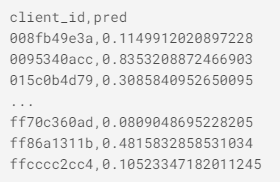

## Чтение данных

In [1]:
# импорт всех необходимых библиотек для работы
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklift.models import ClassTransformation
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ShuffleSplit
from sklearn.feature_selection import mutual_info_classif

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)

import warnings
warnings.filterwarnings('ignore')

randomstate = 42

In [2]:
# загрузка данных из файлов
train_purch = pd.read_csv('train_purch.csv')
train = pd.read_csv('train.csv')

test_purch = pd.read_csv('test_purch.csv')
test = pd.read_csv('test.csv')

clnt = pd.read_csv('clients2.csv')
prdct = pd.read_csv('products.csv')

In [3]:
# напишем функцию, чтобы не выполнять одни и те же действия при изучении данных
def def_info(df):
    print('Размер таблицы:', df.shape)
    print('____________________________________')
    print()
    print('Общая информация')
    print(df.info())
    print('____________________________________')
    print()
    print('Вывод 5и первых строк')
    display(df.head())
    print('____________________________________')
    print()
    print('Доля пропусков в таблице:')
    print(df.isna().mean())
    print('____________________________________')
    print()
    print('Доля явных дублей в данных:', df.duplicated().mean())

### train_purch

In [35]:
def_info(train_purch)

Размер таблицы: (15998952, 13)
____________________________________

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15998952 entries, 0 to 15998951
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   client_id                object 
 1   transaction_id           object 
 2   transaction_datetime     object 
 3   regular_points_received  float64
 4   express_points_received  float64
 5   regular_points_spent     float64
 6   express_points_spent     float64
 7   purchase_sum             float64
 8   store_id                 object 
 9   product_id               object 
 10  product_quantity         float64
 11  trn_sum_from_iss         float64
 12  trn_sum_from_red         float64
dtypes: float64(8), object(5)
memory usage: 1.5+ GB
None
____________________________________

Вывод 5и первых строк


,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,0.0
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,0.0
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,0.0
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,0.0
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,0.0


____________________________________

Доля пропусков в таблице:
client_id                  0.0
transaction_id             0.0
transaction_datetime       0.0
regular_points_received    0.0
express_points_received    0.0
regular_points_spent       0.0
express_points_spent       0.0
purchase_sum               0.0
store_id                   0.0
product_id                 0.0
product_quantity           0.0
trn_sum_from_iss           0.0
trn_sum_from_red           0.0
dtype: float64
____________________________________

Доля явных дублей в данных: 0.0


In [5]:
# заменим пропуски на нули
train_purch.trn_sum_from_red = train_purch.trn_sum_from_red.fillna(0)

### train

In [36]:
def_info(train)

Размер таблицы: (140027, 2)
____________________________________

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140027 entries, 0 to 140026
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   client_id  140027 non-null  object
 1   target     140027 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.1+ MB
None
____________________________________

Вывод 5и первых строк


,client_id,target
0,ad6561e2d8,1
1,7c1ccbf93f,1
2,b58fadcab6,1
3,e99e6fabb9,1
4,27fb6f8520,1


____________________________________

Доля пропусков в таблице:
client_id    0.0
target       0.0
dtype: float64
____________________________________

Доля явных дублей в данных: 0.0


In [7]:
# напишем функцию для определения таргета
def target_def(row):
    treatment_flg = row['treatment_flg']
    purchased = row['purchased']
    if treatment_flg + purchased == 2:
        return 1
    elif treatment_flg + purchased == 0:
        return 1
    else:
        return 0

In [8]:
# применим функцию к нашему датасету
train['target'] = train.apply(target_def, axis=1)
# удалим treatment_flg и purchased использовать их нельзя при обучении, т.к. будет утечка данных 
train = train.drop(['treatment_flg', 'purchased'], axis=1)
train.head()

,client_id,target
0,ad6561e2d8,1
1,7c1ccbf93f,1
2,b58fadcab6,1
3,e99e6fabb9,1
4,27fb6f8520,1


In [9]:
# прверим баланс классов
train.target.mean()

0.5168503217236676

### test_purch

In [37]:
def_info(test_purch)

Размер таблицы: (6883738, 13)
____________________________________

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6883738 entries, 0 to 6883737
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   client_id                object 
 1   transaction_id           object 
 2   transaction_datetime     object 
 3   regular_points_received  float64
 4   express_points_received  float64
 5   regular_points_spent     float64
 6   express_points_spent     float64
 7   purchase_sum             float64
 8   store_id                 object 
 9   product_id               object 
 10  product_quantity         float64
 11  trn_sum_from_iss         float64
 12  trn_sum_from_red         float64
dtypes: float64(8), object(5)
memory usage: 682.7+ MB
None
____________________________________

Вывод 5и первых строк


,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,a375a035b9,2.0,50.0,0.0
1,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,6f9e02ee36,1.0,90.0,0.0
2,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,42e1eb8d23,1.0,20.0,0.0
3,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,5c6de3010f,2.0,85.0,0.0
4,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,343e841aaa,1.0,58.0,0.0


____________________________________

Доля пропусков в таблице:
client_id                  0.0
transaction_id             0.0
transaction_datetime       0.0
regular_points_received    0.0
express_points_received    0.0
regular_points_spent       0.0
express_points_spent       0.0
purchase_sum               0.0
store_id                   0.0
product_id                 0.0
product_quantity           0.0
trn_sum_from_iss           0.0
trn_sum_from_red           0.0
dtype: float64
____________________________________

Доля явных дублей в данных: 0.0


In [11]:
# заменим пропуски на нули
test_purch.trn_sum_from_red = test_purch.trn_sum_from_red.fillna(0)

### test

In [38]:
def_info(test)

Размер таблицы: (60012, 1)
____________________________________

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60012 entries, 0 to 60011
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  60012 non-null  object
dtypes: object(1)
memory usage: 469.0+ KB
None
____________________________________

Вывод 5и первых строк


,client_id
0,a9a604ed6e
1,ebd7360016
2,908cd9b8e8
3,dceb8ce861
4,f4f0ac6b06


____________________________________

Доля пропусков в таблице:
client_id    0.0
dtype: float64
____________________________________

Доля явных дублей в данных: 0.0


### clnt

In [39]:
def_info(clnt)

Размер таблицы: (200039, 5)
____________________________________

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200039 entries, 0 to 200038
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   client_id          200039 non-null  object
 1   first_issue_date   200039 non-null  object
 2   first_redeem_date  200039 non-null  object
 3   age                200039 non-null  int64 
 4   gender             200039 non-null  object
dtypes: int64(1), object(4)
memory usage: 7.6+ MB
None
____________________________________

Вывод 5и первых строк


,client_id,first_issue_date,first_redeem_date,age,gender
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,00010925a5,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
3,0001f552b0,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F
4,00020e7b18,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U


____________________________________

Доля пропусков в таблице:
client_id            0.0
first_issue_date     0.0
first_redeem_date    0.0
age                  0.0
gender               0.0
dtype: float64
____________________________________

Доля явных дублей в данных: 0.0


In [14]:
# удалим колонку client_id.1
clnt = clnt.drop('client_id.1', axis=1)

In [15]:
clnt.loc[clnt['first_redeem_date'].isna(), 'first_redeem_date'] = 0

### prdct

In [40]:
def_info(prdct)

Размер таблицы: (43038, 11)
____________________________________

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43038 entries, 0 to 43037
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   product_id        43038 non-null  object 
 1   level_1           43035 non-null  object 
 2   level_2           43035 non-null  object 
 3   level_3           43035 non-null  object 
 4   level_4           43035 non-null  object 
 5   segment_id        41466 non-null  float64
 6   brand_id          37838 non-null  object 
 7   vendor_id         43004 non-null  object 
 8   netto             43035 non-null  float64
 9   is_own_trademark  43038 non-null  int64  
 10  is_alcohol        43038 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 3.6+ MB
None
____________________________________

Вывод 5и первых строк


,product_id,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
0,0003020d3c,c3d3a8e8c6,c2a3ea8d5e,b7cda0ec0c,6376f2a852,123.0,394a54a7c1,9eaff48661,0.400,0,0
1,0003870676,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,acd3dd483f,10486c3cf0,0.680,0,0
2,0003ceaf69,c3d3a8e8c6,f2333c90fb,419bc5b424,f6148afbc0,271.0,f597581079,764e660dda,0.500,0,0
3,000701e093,ec62ce61e3,4202626fcb,88a515c084,48cf3d488f,172.0,54a90fe769,03c2d70bad,0.112,0,0
4,0007149564,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,63417fe1f3,f329130198,0.600,0,0


____________________________________

Доля пропусков в таблице:
product_id          0.000000
level_1             0.000070
level_2             0.000070
level_3             0.000070
level_4             0.000070
segment_id          0.036526
brand_id            0.120823
vendor_id           0.000790
netto               0.000070
is_own_trademark    0.000000
is_alcohol          0.000000
dtype: float64
____________________________________

Доля явных дублей в данных: 0.0


## Дополнительные функции

In [17]:
# функция для изучения выбросов и аномалий в данных
def boxplot_table(df, column):
    _, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(10, 4), 
                                         sharex=True,
                                         gridspec_kw=dict(height_ratios=[4,.8]))
    hist = sns.histplot(data=df, x=column, kde=True, ax=axs_hist)
    box = sns.boxplot(data=df, x=column, orient='h', ax=axs_box)
    hist.set(title='Гистограмма распределения',
             ylabel='Количество записей');
# цикл для посьроения графиков по всем полям цифровым
# for col in df_features.select_dtypes(include='number').columns:
#     boxplot_table(df_features, col)

In [18]:
# функция для изучения распределения данных по целевому признаку
def result_table(data, column):
    table = (data.groupby(column)['target'].agg(['sum', 'count'])
    .assign(share = lambda x: x['sum'] / x['count'])
    ).sort_values(by='share', ascending=False).style.background_gradient(low=0.1, cmap='YlOrRd')
    return table
# for col in df_features.columns:
#     display(result_table(df, col))

## Подготовка признаков

In [19]:
def features_normal():
    # объеденим таблицы train_purch и test_purch
    # дальнейшее деление на выборки будет происходить по индексу, который будет равен client_id
    purch = pd.concat([train_purch, test_purch]).set_index('client_id')
    # создадим признак среднего чека по клиентам
    purch_mean = (purch[['transaction_id', 'purchase_sum']]
                  .drop_duplicates()
                  .groupby('client_id')['purchase_sum'].agg(['mean', 'sum', 'max', 'min'])
                 )
    # создадим признак кол-ва чеков
    purch_chek = (purch[['transaction_id']]
                  .drop_duplicates()
                  .groupby('client_id')['transaction_id'].count()
                 )
    purch_var = (purch[['transaction_id','regular_points_received', 'express_points_received'
                        , 'regular_points_spent', 'express_points_spent', 'product_quantity'
                        , 'trn_sum_from_iss', 'trn_sum_from_red']]
                  .drop_duplicates()
                  .groupby('client_id')['regular_points_received', 'express_points_received'
                                        , 'regular_points_spent', 'express_points_spent'
                                        , 'product_quantity', 'trn_sum_from_iss', 'trn_sum_from_red'].sum()
                 )
    prdct_fut = (pd.merge(purch.reset_index()
                          , prdct[['product_id', 'is_own_trademark', 'is_alcohol']]
                          , on='product_id'
                          , how='left')
                 .set_index('client_id')
                )
    prdct_fut = (prdct_fut[['is_own_trademark', 'is_alcohol']]
                 .groupby('client_id')['is_own_trademark', 'is_alcohol'].mean()
                )
    purch_date = (purch[['transaction_id', 'transaction_datetime']]
                  .drop_duplicates()
                  .groupby('client_id')['transaction_datetime'].agg(['last', 'first'])
                 )
    purch_date['first_unix'] = pd.to_datetime(purch_date['first']).astype('int64')/10**9
    purch_date['last_unix'] = pd.to_datetime(purch_date['last']).astype('int64')/10**9
    purch_date['day_unix']  = purch_date['last_unix'] - purch_date['first_unix']
    purch_date['day']  = (pd.to_datetime(purch_date['last']) - pd.to_datetime(purch_date['first'])).astype('timedelta64[D]')
    purch_date = purch_date.drop(['first', 'last'], axis=1)
    
    df_train = train.copy().set_index('client_id')
    df_features = clnt.copy().set_index('client_id')
    
    # выполним преобразования для приведения даты к unix time stamp — в таком формате признак можно использовать в моделях
    # в результате приведения даты к целочисленному виду мы получаем число в наносекундах
    # выполним деление на миллиард
    df_features['first_issue'] = pd.to_datetime(df_features['first_issue_date']).astype('int64')/10**9
    df_features['first_redeem'] = pd.to_datetime(df_features['first_redeem_date']).astype('int64')/10**9
    df_features['delay_unix']  = df_features['first_redeem'] - df_features['first_issue']
    df_features['delay']  = (pd.to_datetime(df_features['first_redeem_date']) - pd.to_datetime(df_features['first_issue_date'])).astype('timedelta64[D]')
    df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)
    # добавим признаки среднего чека и суммы всех продаж по клиентам
    
    df_features = (df_features.join([purch_mean, purch_chek, prdct_fut, purch_var, purch_date], how='left')
                  )
    # обработка аномалий/ все выбросы заменены на среднее, анализ был проведен в тетради не отражен
    # ниже функция для графического вывода выбросов по полям
    # выбросы в поле возраста заменим на среднее
    df_features.loc[df_features['age'] < 18, 'age'] = df_features.query('age > 0 and age <= 100')['age'].mean()
    df_features.loc[df_features['age'] > 100, 'age'] = df_features.query('age > 0 and age <= 100')['age'].mean()
    # # выбросы в поле delay заменим на среднее
    df_features.loc[df_features['delay'] < 0, 'delay'] = 0
    
    df_features = df_features.drop(['gender'], axis=1)
    
    return df_features, df_train

## Подготовка сетов

In [20]:
def set_new(df_features):
    
    indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.25, random_state=randomstate)
    indices_test = pd.Index(set(df_features.index) - set(df_train.index))
    X_train = df_features.loc[indices_learn, :]
    y_train = df_train.loc[indices_learn, 'target']
    
    X_val = df_features.loc[indices_valid, :]
    y_val = df_train.loc[indices_valid, 'target']
    
    X_train_full = df_features.loc[df_train.index, :]
    y_train_full = df_train.loc[:, 'target']
    
    X_test = df_features.loc[indices_test, :]
    
    return X_train, y_train, X_val, y_val, X_train_full, y_train_full, X_test

In [21]:
models_results = {
            'model': [],
            'best_score': [],
            'rocauc': [],
            'gini': []
        }

## Подбор гиперпараметров

In [22]:
df_features, df_train = features_normal()
X_train, y_train, X_val, y_val, X_train_full, y_train_full, X_test = set_new(df_features)

### LGBM

In [23]:
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  eval_metric=['auc'],
                  verbose = 100)

params = {'n_estimators': range(20, 501, 20),
          'learning_rate': [0.001, 0.01, 0.1, .5],
          'max_depth': range(2, 36, 1),
          'num_leaves': range(2, 129, 2),
          'boosting_type': ['gbdt', 'dart', 'goss']
          
         }

lgbm = LGBMClassifier(random_state=randomstate)
grid_cv_2 = RandomizedSearchCV(lgbm, params, scoring='precision', cv=3)
grid_cv_2.fit(X_train, y_train, **fit_params)

[100]	valid_0's auc: 0.643229	valid_0's binary_logloss: 0.682126	valid_1's auc: 0.51811	valid_1's binary_logloss: 0.689761
[100]	valid_0's auc: 0.635026	valid_0's binary_logloss: 0.681908	valid_1's auc: 0.518496	valid_1's binary_logloss: 0.689628
[200]	valid_0's auc: 0.679423	valid_0's binary_logloss: 0.675374	valid_1's auc: 0.519071	valid_1's binary_logloss: 0.68958
[100]	valid_0's auc: 0.627734	valid_0's binary_logloss: 0.682059	valid_1's auc: 0.516529	valid_1's binary_logloss: 0.689845
[200]	valid_0's auc: 0.680473	valid_0's binary_logloss: 0.675007	valid_1's auc: 0.518585	valid_1's binary_logloss: 0.689537
[100]	valid_0's auc: 0.544075	valid_0's binary_logloss: 0.687587	valid_1's auc: 0.523644	valid_1's binary_logloss: 0.689269
[200]	valid_0's auc: 0.549374	valid_0's binary_logloss: 0.687052	valid_1's auc: 0.520978	valid_1's binary_logloss: 0.689284
[100]	valid_0's auc: 0.544117	valid_0's binary_logloss: 0.687576	valid_1's auc: 0.527146	valid_1's binary_logloss: 0.689027
[200]	vali

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(random_state=42),
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'learning_rate': [0.001, 0.01, 0.1,
                                                          0.5],
                                        'max_depth': range(2, 36),
                                        'n_estimators': range(20, 501, 20),
                                        'num_leaves': range(2, 129, 2)},
                   scoring='precision')

In [24]:
best_lgbm_2 = grid_cv_2.best_estimator_
grid_cv_2.best_score_, grid_cv_2.best_params_

(0.5210123747047225,
 {'num_leaves': 84,
  'n_estimators': 240,
  'max_depth': 3,
  'learning_rate': 0.1,
  'boosting_type': 'dart'})

In [25]:
rocauc = roc_auc_score(y_val, best_lgbm_2.predict(X_val))
rocauc, rocauc*2-1

(0.5087402848757564, 0.017480569751512798)

In [26]:
models_results['model'].append('LGBM')
models_results['best_score'].append(grid_cv_2.best_score_)
models_results['rocauc'].append(rocauc)
models_results['gini'].append(rocauc*2-1)

lgb = pd.DataFrame({
    'feature_name': best_lgbm_2.feature_name_,
    'feature_score': best_lgbm_2.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

lgb.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,first_redeem,402
1,age,136
2,last_unix,122
3,regular_points_received,111
4,express_points_spent,94
5,min,93
6,mean,83
7,first_issue,79
8,delay_unix,73
9,day_unix,69


### CatBoost

In [27]:
# подберем гипперпарметры для модели
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  verbose = 100)

cbc = CatBoostClassifier(loss_function='Logloss', random_state=randomstate)
parameters = {'depth': range(4,17,4),
              'learning_rate': [.01, .1],
              'iterations': range(100,501,100)
             }
grid_cbc_2 = RandomizedSearchCV(cbc, parameters, scoring='recall', cv=3)
grid_cbc_2.fit(X_train, y_train, **fit_params)

0:	learn: 0.6911627	test: 0.6916235	test1: 0.6926858	best: 0.6926858 (0)	total: 403ms	remaining: 3m 21s
100:	learn: 0.5576889	test: 0.6046328	test1: 0.6982799	best: 0.6913238 (6)	total: 24.8s	remaining: 1m 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6913237521
bestIteration = 6

Shrink model to first 7 iterations.
0:	learn: 0.6912986	test: 0.6916000	test1: 0.6922191	best: 0.6922191 (0)	total: 251ms	remaining: 2m 5s
100:	learn: 0.5582187	test: 0.6051705	test1: 0.6989080	best: 0.6907347 (8)	total: 24.6s	remaining: 1m 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6907347188
bestIteration = 8

Shrink model to first 9 iterations.
0:	learn: 0.6912694	test: 0.6916424	test1: 0.6923876	best: 0.6923876 (0)	total: 239ms	remaining: 1m 59s
100:	learn: 0.5546552	test: 0.6025414	test1: 0.6978510	best: 0.6906038 (16)	total: 24s	remaining: 1m 34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6906038322
bestIteration = 16

Sh

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000028D1AEE4DF0>,
                   param_distributions={'depth': range(4, 17, 4),
                                        'iterations': range(100, 501, 100),
                                        'learning_rate': [0.01, 0.1]},
                   scoring='recall')

In [28]:
best_cbc_2 = grid_cbc_2.best_estimator_
grid_cbc_2.best_score_, grid_cbc_2.best_params_

(0.9230372661658567, {'learning_rate': 0.01, 'iterations': 400, 'depth': 4})

In [29]:
cbc = pd.DataFrame({
    'feature_name': best_cbc_2.feature_names_,
    'feature_score': best_cbc_2.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

cbc.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,first_redeem,76.585260
1,express_points_spent,3.150238
2,age,2.811648
3,mean,1.421979
4,max,1.359797
5,regular_points_spent,1.287664
6,regular_points_received,1.286435
7,product_quantity,1.250205
8,trn_sum_from_red,1.189538
9,min,1.130449


In [30]:
rocauc = roc_auc_score(y_val, best_cbc_2.predict(X_val))
rocauc, rocauc*2-1

(0.5070054517045658, 0.014010903409131581)

In [31]:
models_results['model'].append('CatBoost')
models_results['best_score'].append(grid_cbc_2.best_score_)
models_results['rocauc'].append(rocauc)
models_results['gini'].append(rocauc*2-1)

## Тестирование лучшей модели

In [32]:
pd.DataFrame(data=models_results)

,model,best_score,rocauc,gini
0,LGBM,0.521012,0.508740,0.017481
1,CatBoost,0.923037,0.507005,0.014011


In [33]:
# обучим модель на всех данных
model = best_lgbm_2
model.fit(X_train_full, y_train_full)
# сделаем предсказания на тестовых данных
X_test_pred = X_test.copy()
X_test_pred.loc[:, 'pred'] = model.predict(X_test.values)

In [34]:
# выгрузим в csv
sub = X_test_pred[['pred']].to_csv('baseline.csv')
!head -n 5 baseline.csv

"head" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


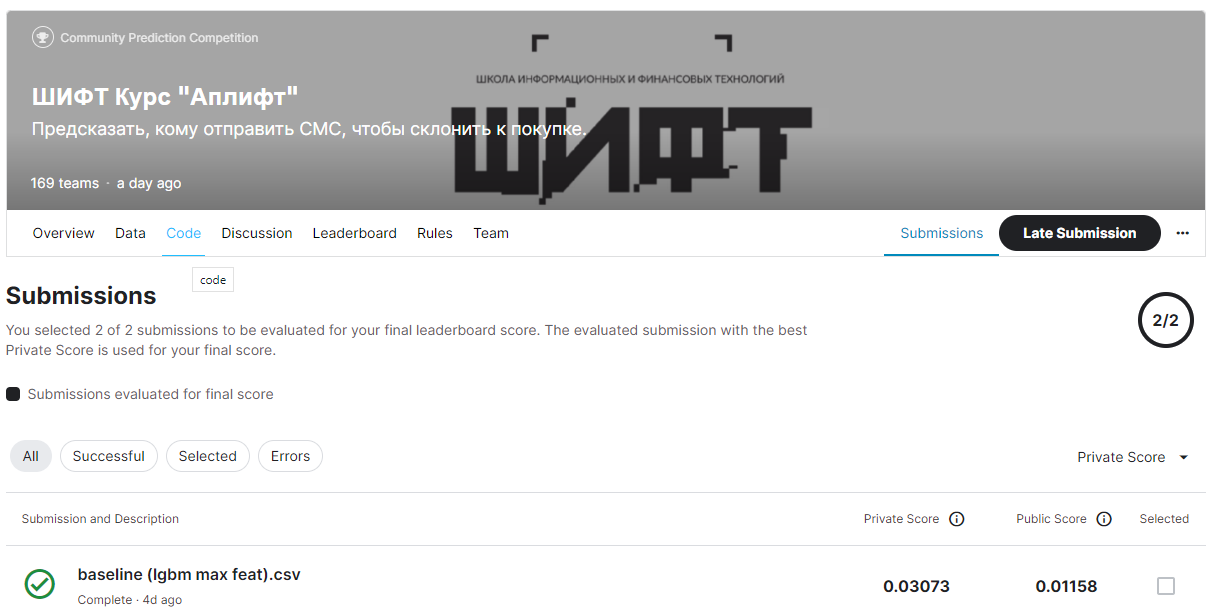